# Neural Network from scratch without using sk-learn, PyTorch or TensorFlow

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [292]:
df = pd.read_csv('../data/WineQT.csv')
df = df.drop('Id', axis = 1) # To drop the Id column

In [293]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

## Train-Test split

In [294]:
nrow = df.shape[0]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Here, I initialize an index to train my model on 75% of the data to test it afterward on the 25% left
train_test_index = int(nrow * 0.75)

train_df = df.iloc[:train_test_index]
test_df = df.iloc[train_test_index:]



In [295]:
X_train = train_df.iloc[:,:-1].to_numpy()
y_train = train_df.iloc[:,-1].to_numpy() - 3

X_test  = test_df.iloc[:,:-1].to_numpy()
y_test  = test_df.iloc[:,-1].to_numpy() - 3



## Normalize the data

In [296]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_norm = (X_train - mean) / std
X_train_norm = np.asarray(X_train_norm, dtype=np.float32)

X_test_norm = (X_test - mean) / std
X_test_norm = np.asarray(X_test_norm, dtype=np.float32)


## Create the Neural Network

In [297]:
np.random.seed(42)
Conf_Matrix = np.zeros((6, 6), dtype=int)

class Layer_Dense :
    def __init__(self,n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2.0 / n_inputs)
        self.biases = np.zeros((1,n_neurons))
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues, lr):
        m = self.inputs.shape[0]
        self.dweights = self.inputs.T @ dvalues 
        self.dbiases  = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs  = dvalues @ self.weights.T

        self.weights -= lr * self.dweights
        self.biases  -= lr * self.dbiases
        return self.dinputs
    

class Activation_ReLU:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    def backward(self, dvalues):
        dZ = dvalues.copy()
        dZ[self.inputs <= 0] = 0
        return dZ


class Activation_Softmax:
    def forward(self, inputs):
        exps = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)

class Loss_CategoricalCrossentropy:
    def forward(self, y_pred, y_true):
        eps = 1e-7
        y_pred = np.clip(y_pred, eps, 1-eps)
        return -np.log(y_pred[np.arange(len(y_true)), y_true])
    def calculate(self, y_pred, y_true):
        return self.forward(y_pred, y_true).mean()


def dloss_dlogits(y_pred, y_true):
    Y = np.zeros_like(y_pred); Y[np.arange(len(y_true)), y_true] = 1
    return (y_pred - Y) / y_pred.shape[0]

def confusion_matrix(y_true, y_pred, K):
    for t, p in zip(y_true, y_pred):
        Conf_Matrix[t, p] += 1

In [298]:
layer1 = Layer_Dense(11,64)
activation1 = Activation_ReLU()
layer2 = Layer_Dense(64,32)
activation2 = Activation_ReLU()
layer3 = Layer_Dense(32,16)
activation3 = Activation_ReLU()
layer4 = Layer_Dense(16,6)
activation4 = Activation_Softmax()

### Forward pass

In [299]:
def forward_pass(X_values):
    layer1.forward(X_values)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    activation4.forward(layer4.output)
    return activation4.output

### Backward pass

## Gradient descent

In [300]:
def gradient_descent(epochs, learning_rate, X_data, y_data, batch_size, K, seed = None):
    y_adjusted = y_data.astype(int).ravel()
    n = X_data.shape[0]
    rng = np.random.default_rng(seed)

    loss_graph = []
    accuracy_graph = []

    loss_function = Loss_CategoricalCrossentropy()
    
    for ep in range(1, epochs +1):
        idx = rng.permutation(n)
        epoch_loss_sum = 0.0
        correct = 0   

        for start in range (0, n, batch_size):
            b = idx[start:start + batch_size]
            Xb,yb = X_data[b], y_adjusted[b]
            m = yb.shape[0]
            forward_pass(Xb)

            loss = loss_function.calculate(activation4.output, yb)

            epoch_loss_sum += loss * m

            y_pred_classes = np.argmax(activation4.output, axis=1)
            correct += np.sum(y_pred_classes == yb)

            dlogits = dloss_dlogits(activation4.output, yb)
            dlayer4 = layer4.backward(dlogits, learning_rate)
            dactivation3 = activation3.backward(dlayer4)
            dlayer3 = layer3.backward(dactivation3, learning_rate)
            dactivation2 = activation2.backward(dlayer3)
            dlayer2 = layer2.backward(dactivation2, learning_rate)
            dactivation1 = activation1.backward(dlayer2)
            layer1.backward(dactivation1, learning_rate)

        epoch_loss = epoch_loss_sum / n
        loss_graph.append(epoch_loss)
        
        forward_pass(X_data)

        # Prédictions de classes
        y_pred_classes = np.argmax(activation4.output, axis=1)

        # Accuracy
        acc = np.mean(y_pred_classes == y_adjusted)
        accuracy_graph.append(acc)

        print(f"Epoch {ep+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

    axes[0].plot(loss_graph)
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss over batches')

    axes[1].plot(accuracy_graph)
    axes[1].set_xlabel('Batch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy over batches')

    plt.tight_layout()
    plt.show()

  

## Training the model

Epoch 2, Loss: 1.6413, Accuracy: 0.3699
Epoch 3, Loss: 1.5780, Accuracy: 0.4084
Epoch 4, Loss: 1.7370, Accuracy: 0.4399
Epoch 5, Loss: 1.5481, Accuracy: 0.4516
Epoch 6, Loss: 1.5953, Accuracy: 0.4772
Epoch 7, Loss: 1.5052, Accuracy: 0.4912
Epoch 8, Loss: 1.2041, Accuracy: 0.4971
Epoch 9, Loss: 1.3373, Accuracy: 0.5076
Epoch 10, Loss: 1.2158, Accuracy: 0.5158
Epoch 11, Loss: 1.1246, Accuracy: 0.5228
Epoch 12, Loss: 1.4046, Accuracy: 0.5309
Epoch 13, Loss: 1.2340, Accuracy: 0.5368
Epoch 14, Loss: 1.4453, Accuracy: 0.5379
Epoch 15, Loss: 1.3109, Accuracy: 0.5403
Epoch 16, Loss: 1.1158, Accuracy: 0.5403
Epoch 17, Loss: 1.1204, Accuracy: 0.5426
Epoch 18, Loss: 1.2384, Accuracy: 0.5449
Epoch 19, Loss: 1.2887, Accuracy: 0.5461
Epoch 20, Loss: 1.1099, Accuracy: 0.5461
Epoch 21, Loss: 0.9434, Accuracy: 0.5484
Epoch 22, Loss: 1.0457, Accuracy: 0.5554
Epoch 23, Loss: 1.0057, Accuracy: 0.5589
Epoch 24, Loss: 1.1071, Accuracy: 0.5589
Epoch 25, Loss: 1.0350, Accuracy: 0.5589
Epoch 26, Loss: 0.9409, 

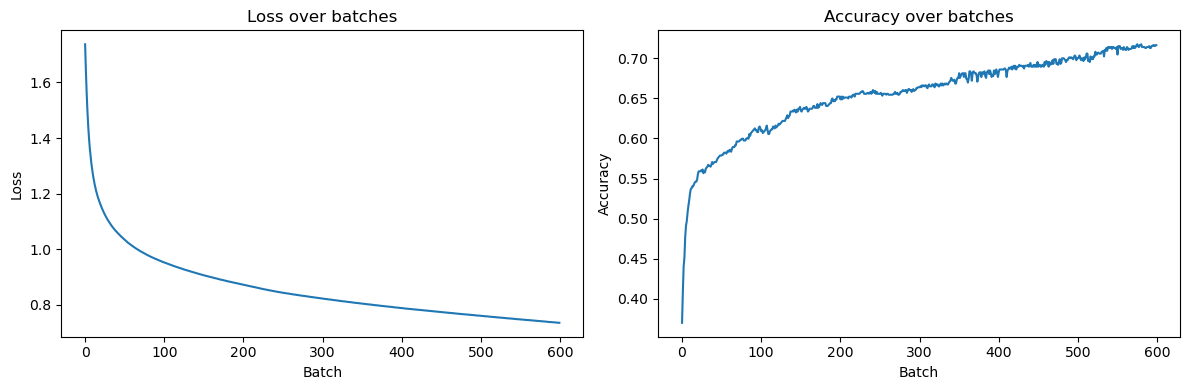

In [301]:
gradient_descent(epochs=600, learning_rate=0.001, X_data=X_train_norm, y_data=y_train, batch_size = 32, K = 6, seed = 42)

## Testing it with testing data

In [302]:
loss_function = Loss_CategoricalCrossentropy()

forward_pass(X_test_norm)

loss = loss_function.calculate(activation4.output, y_test)
acc = (np.argmax(forward_pass(X_test_norm), axis=1) == y_test).mean()

print(f"Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Loss: 1.1366, Accuracy: 0.5524
